In [1]:
! pip install --no-cache-dir --upgrade git+https://github.com/evfro/polara.git@develop#egg=polara

  Cloning https://github.com/evfro/polara.git (to revision develop) to /tmp/pip-install-42drtd9b/polara_eca36727f87c421694672ba24eca8a26
  Running command git clone -q https://github.com/evfro/polara.git /tmp/pip-install-42drtd9b/polara_eca36727f87c421694672ba24eca8a26
  Running command git checkout -b develop --track origin/develop
  Switched to a new branch 'develop'
  Branch 'develop' set up to track remote branch 'develop' from 'origin'.
  Created wheel for polara: filename=polara-0.7.2.dev0-py3-none-any.whl size=87177 sha256=eba73e2855e10b9c2bae3238d51c304f40b8d059f67d38e6c8a8e9c8ae6e2905
  Stored in directory: /tmp/pip-ephem-wheel-cache-697ihby7/wheels/19/88/81/920c4189a6b0b92f19b02f18fcb44ded22ae852f7b09ab2e28
Successfully built polara


In [54]:
from polara import SVDModel
from polara.recommender.data import RecommenderData
import numpy as np
import pandas as pd
from tqdm import tqdm
from matplotlib import pyplot as plt

from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve
from lightgbm import LGBMClassifier,plot_importance
from itertools import product

from evaluation import topn_recommendations, model_evaluate, downvote_seen_items

## Data preprocessing and analysis 

In [3]:
memes = pd.read_csv('memes.csv', names=['meme_id', 'file_id', 'author_id', 'timestamp', 
                                        'filetype', 'unique_id', 'caption' ], header=None)
users_memes = pd.read_csv('users_memes.csv', names=['id__', 'chat_id', 'meme_id', 'reaction',
                                        'timestamp', 'message_id', 'timestamp_reaction'], header=None)
users = pd.read_csv('users.csv', names=['chat_id', 'name', '?', 'username',
                                        'date_add', 'is_fresh', '??'], header=None)

In [8]:
data = users_memes[['chat_id', 'meme_id', 'reaction', 'timestamp']].copy()
data.sort_values(by='timestamp', inplace=True) # sort data by time

REACTION2VALUE = {1001: -1, 107: -1, 106: -1, 105: -1, 104: -1,
                  103: 1, 102: 1, 101: 1, 100: 1, 1000: 1, 1002 : None} # 1002 means empty

data.reaction = users_memes.reaction.map(REACTION2VALUE)
data = data.dropna(axis='index', how='any', subset=['reaction'])

data.head()

,chat_id,meme_id,reaction,timestamp
882,354637850,398,-1.0,2021-12-08 20:35:19.000000
883,354637850,222,-1.0,2021-12-08 20:35:35.000000
884,481807223,387,1.0,2021-12-08 20:37:15.000000
885,354886383,61,-1.0,2021-12-08 20:39:05.000000
886,354886383,182,-1.0,2021-12-08 20:39:11.000000


In [33]:
train_data = data.copy()
train_data.drop_duplicates(subset=['chat_id', 'meme_id'], inplace=True)

<BarContainer object of 6240 artists>

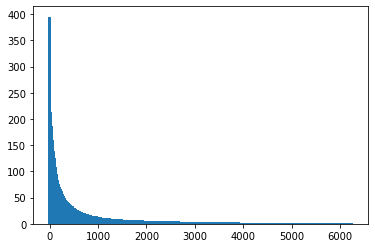

In [34]:
meme_sorted = train_data.meme_id.value_counts().values
x = [i for i in range(len(meme_sorted))]
plt.bar(x, height=meme_sorted, width=50)

In [36]:
# let's leave only those users that have at least 10 reactions on memes
n_reactions = 10
train_data = train_data.loc[
    train_data
    .groupby('chat_id')['chat_id']
    .transform('count') >= n_reactions
]

num of unique users:  1060
num of unique memes:  6240
num of users that have at least 10 reactions:  873


In [37]:
data_model_1 = RecommenderData(train_data, 'chat_id', 'meme_id', 'reaction')
data_model_1.warm_start = False
data_model_1.holdout_size = 1
data_model_1.test_ratio = 0.2

train_val = data_model_1.training
holdout_test = data_model_1.test[1] #holdout
data_indexing_tvt = data_model_1.index


data_model_2 = RecommenderData(train_val, 'chat_id', 'meme_id', 'reaction')
data_model_2.warm_start = False
data_model_2.holdout_size = 1
data_model_2.test_ratio = 0.2

train = data_model_2.training
holdout_val = data_model_2.test[1] #holdout
data_indexing_tv = data_model_2.index



Preparing data...
Users are not uniformly ordered! Unable to split test set reliably.
6 unique meme_id entities within 6 holdout interactions were filtered. Reason: not in the training data.
Done.
There are 69486 events in the training and 169 events in the holdout.
Preparing data...
Users are not uniformly ordered! Unable to split test set reliably.
4 unique meme_id entities within 4 holdout interactions were filtered. Reason: not in the training data.
Done.
There are 69311 events in the training and 171 events in the holdout.


## Random

In [68]:
data_description = dict(
    users = train_val['chat_id'].name,
    items = train_val['meme_id'].name,
    feedback = 'reaction',
    n_users = len(train_val['chat_id']),
    n_items = len(train_val['meme_id']),
    test_users = holdout_test[train_val['chat_id'].name].values
)

testset = data_description['test_users']
seen_data = train_val[train_val.chat_id.isin(testset)]

In [72]:
print(f'train size = {train.shape[0]}, val size = {holdout_val.shape[0]}, test size = {holdout_test.shape[0]}')

train size = 69311, val size = 171, test size = 169


In [102]:
scores = np.random.uniform(0,1, (holdout_test.chat_id.nunique(), train_val.meme_id.nunique()))

downvote_seen_items(np.array(scores), seen_data, data_description)
recs = topn_recommendations(np.array(scores), topn=10)

hr, mrr, cov = model_evaluate(recs, holdout_test, data_description,  topn=10)
print('--------test--------')
print(f'HR={hr}, MRR={mrr}, COV={cov}')

--------test--------
HR=0.005917159763313609, MRR=0.0029585798816568047, COV=0.02111216647957862


## Popularity

In [125]:
popularity = train_val[train_val['reaction'] == 1].meme_id.value_counts()
top10 = list(popularity[:10].keys())

In [126]:
top10

[33, 31, 2201, 6, 1946, 4324, 51, 4297, 2490, 182]

In [127]:
one_score = np.zeros(train_val.meme_id.nunique())
one_score[top10] = 1

scores = [one_score for i in range(holdout_test.chat_id.nunique())]
scores = np.array(scores)

In [128]:
scores.shape

(169, 6234)

In [129]:
downvote_seen_items(np.array(scores), seen_data, data_description)
recs = topn_recommendations(np.array(scores), topn=10)

hr, mrr, cov = model_evaluate(recs, holdout_test, data_description,  topn=10)
print('--------test--------')
print(f'HR={hr}, MRR={mrr}, COV={cov}')

--------test--------
HR=0.1301775147928994, MRR=0.015053536207382362, COV=0.00014391388193305126
